# Publishing Figures - Single Kappa
This obtains all figures for a comparison between two simulations of neighbouring optical depth that only require the surface variables.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-12-04 14:50:32,081 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
           'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
color_seq_exp = ['b', 'g', 'r']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
n_kappa = len(kappa_names)
ds = [[] for i in range(n_exp)]
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[i] + kappa_names[j])[var_keep]
            ds[i] += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
            namelist = isca_tools.load_namelist(exp_dir[i] + kappa_names[j])  # Need this for albedo_value
            if i == 0:
                albedo += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
p_surface = float(ds[0][0].pfull) * 100

100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

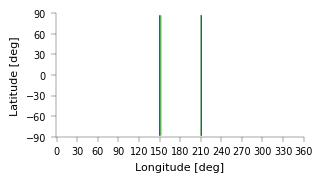

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir[1], kappa_names[0], 'land.nc')
# isca_tools.plot.show_land(land_file_name)
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

if save_fig or save_land_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [291]:
# Load in across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20

mean_method = 'land'
# mean_method = 'all'

lat_use_ind = np.where((np.abs(ds[0][0].lat) <= lat_max) & (np.abs(ds[0][0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0][0].lat))[lat_use_ind]

ds_all = [[] for i in range(n_exp)]
ds_mean = [[] for i in range(n_exp)]
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
            
            if 'aqua' not in exp_names[i].lower():
                # if not aquaplanet, then is land and only consider land longitudes
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
            
            if season == 'summer':
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all[i] += [ds_use.load()]
            
            if mean_method == 'land':
                # Only take mean over land coordinates for land simulations
                # For aquaplanet, mean_method is irrelevant.
                ds_mean[i] += [ds_use.mean(dim='lon_time').load()]
            elif mean_method == 'all':
                ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
                ds_mean[i] += [ds_use.mean(dim=['lon', 'time']).load()]
            else:
                raise ValueError(f'Mean method is {mean_method} which is not valid.')
            pbar.update(1)

100%|██████████| 6/6 [01:00<00:00, 10.03s/it]


In [292]:
# Need to choose quantile method, use 'temp' for comparison with land.
# quant_method = 'byrne'      # var_quant2 will be the x percentile of var (as in Byrne 2021)
quant_method = 'temp'       # var_quant2 will be the average of var conditioned on the days with x percentile of temperature

if quant_method == 'byrne':
    label_quant = 'Percentile, $x$'
elif quant_method == 'temp':
    label_quant = 'Temperature percentile, $x$'
else:
    raise ValueError('quant_method is not valid')

# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

temp_mean = np.zeros((n_exp, n_kappa, n_lat))
sphum_mean = np.zeros((n_exp, n_kappa, n_lat))
mse_mean = np.zeros((n_exp, n_kappa, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_kappa, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_kappa, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_kappa, n_lat, n_quant))

with tqdm(total=n_exp*n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            # Get mean values first
            ds_use = ds_mean[i][j]
            temp_mean[i, j] = ds_use.temp
            sphum_mean[i, j] = ds_use.sphum
            mse_mean[i, j] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
            
            ds_use = ds_all[i][j]
            temp_quant2[i, j] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
            if quant_method == 'byrne':
                sphum_quant2[i, j] = ds_use.sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
                mse_quant2[i, j] = ds_use.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
                pbar.update(n_quant*n_lat)
            elif quant_method == 'temp':
                for k in range(n_lat):
                    for q, quant in enumerate(quant_plot):
                        use_ind = get_quant_ind(ds_use.temp[k], quant, 0.5, 0.5)
                        sphum_quant2[i, j, k, q] = ds_use.sphum[k, use_ind].mean()
                        mse_quant2[i, j, k, q] = mse[k, use_ind].mean()
                        pbar.update(1)

100%|██████████| 8316/8316 [00:40<00:00, 207.39it/s]


## Ocean to Ocean Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

This shows that the scaling, $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles.

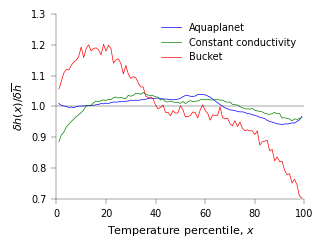

In [293]:
save_lambda_fig = False

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_mse_ratio = np.zeros((n_exp, n_lat, n_quant))
for i in range(n_exp):
    delta_mse_ratio[i] = ((mse_quant2[i, 1]-mse_quant2[i, 0])/np.expand_dims(mse_mean[i, 1] - mse_mean[i, 0], axis=-1))
    ax.plot(quant_plot, np.average(delta_mse_ratio[i], axis=0, weights=lat_weights), label=exp_names[i], color=color_seq_exp[i])
# delta_mse_ratio = var_ratio
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend()
ax.set_xlabel(label_quant)
ax.set_ylabel('$\delta h(x)/\delta \overline{h}$')
ax.set_ylim(0.7,1.3)
ax.set_xlim(0, 100)
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theoretical Temperature Change
Below, we plot whether the theory can correctly predict the temperature change between adjacent simulations.

In [294]:
temp_diff_theory = {method: np.zeros((n_exp, n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda', 'lambda',
                                                                             'linear_full']}
for method in temp_diff_theory:
    for i in range(n_exp):
        for j in range(n_lat):
            temp_diff_theory[method][i, j] = \
                get_delta_temp_quant_theory(temp_mean[i, :, j], sphum_mean[i, :, j], temp_quant2[i, :, j], sphum_quant2[i, :, j], p_surface,
                                            const_rh=True if method=='const_rh' else False,
                                            delta_mse_ratio=delta_mse_ratio[i, j:j+1] if 'lambda' in method else None,
                                            taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')
            temp_diff_theory['linear_full'][i, j] = \
                get_delta_temp_quant_theory(temp_mean[i, :, j], sphum_mean[i, :, j], temp_quant2[i, :, j], sphum_quant2[i, :, j], p_surface,
                                            const_rh=False, delta_mse_ratio=None, taylor_level='linear')

In [295]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude for theory
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too
sf_denom = {key: temp_mean[:, 1]-temp_mean[:,0] for key in temp_diff_theory}
sf_denom['simulated'] = temp_mean[:, 1]-temp_mean[:,0]
for key in sf_denom:
    sf_denom[key] = np.expand_dims(sf_denom[key], axis=-1)

# av_quant_ind = np.zeros((n_exp, n_lat))
# if scaling_factor_av == 'mean':
#     # Find temperature quantile if historical climate closest to mean
#     for i in range(n_exp):
#         for k in range(n_lat):
#             av_quant_ind[i, k] = int(np.round(scipy.stats.percentileofscore(ds_all[i][0].temp[k], float(ds_all[i][0].temp[k].mean()))))
# else:
#     av_quant_ind[:] = 50
# av_quant_ind = numpy_indexed.indices(quant_plot, av_quant_ind)
# av_quant_flat_ind = np.ravel_multi_index((np.arange(n_lat), av_quant_ind), temp_quant2[0].shape)
# sf_denom = {key: temp_diff_theory[key].flatten()[av_quant_flat_ind] for key in temp_diff_theory.keys()}
# if scaling_factor_av == 'mean':
#     sf_denom['simulated'] = temp_mean[1]-temp_mean[0]
# else:
#     sf_denom['simulated'] = (temp_quant2[1]-temp_quant2[0]).flatten()[av_quant_flat_ind]
# for key in sf_denom:
#     sf_denom[key] = np.expand_dims(sf_denom[key], axis=-1)
# if scaling_factor_av_type == 'simulated':
#     for key in temp_diff_theory.keys():
#         # Set all theoretical mean/median predictions to the simulated
#         sf_denom[key] = sf_denom['simulated'] 

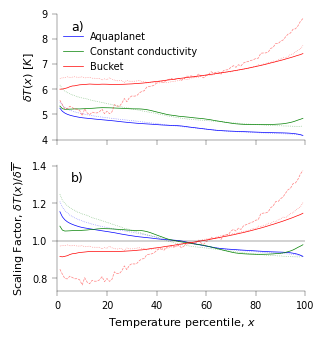

In [296]:
save_theory_fig = False
# theory_plot = 'linear'
theory_plot = 'const_rh'
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.75*2*(width['one_col']/ar)), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average((temp_quant2[i, 1]-temp_quant2[i, 0]), axis=0, weights=lat_weights),
               label = exp_names[i], color=color_seq_exp[i])
    ax[0].plot(quant_plot, np.average(temp_diff_theory['const_rh'][i], axis=0, weights=lat_weights), color=color_seq_exp[i],
               linestyle=':', alpha=0.5)
    ax[1].plot(quant_plot, np.average((temp_quant2[i, 1]-temp_quant2[i, 0])/sf_denom['simulated'][i], axis=0, weights=lat_weights),
               label = exp_names[i], color=color_seq_exp[i])
    ax[1].plot(quant_plot, np.average(temp_diff_theory['const_rh'][i]/sf_denom['const_rh'][i], axis=0, weights=lat_weights), color=color_seq_exp[i], linestyle=':', alpha=0.5)
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'][i], axis=0, weights=lat_weights), 
           color=color_seq_exp[i], linestyle='--', alpha=0.5)
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear'][i]/sf_denom['linear'][i], axis=0, weights=lat_weights), 
           color=color_seq_exp[i], linestyle='--', alpha=0.5)
# ax[1].plot(quant_plot, np.average(((temp_quant2[1]-temp_quant2[0])/sf_denom['simulated'])[lat_use],
#                                   axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
# ax[1].plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', linestyle='--')
# ax[1].plot(quant_plot, np.average((temp_diff_theory['const_rh']/sf_denom['const_rh'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].legend(bbox_to_anchor=(0.6,0.47))
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ [$K$]')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
label_subplots(fig, ax)
ax[0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
ax[0].set_ylim(4, 9)
# ax[1].set_ylim(0.75, 1.35)

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T(x) = \gamma^T \delta \overline{T} + \gamma^{\Delta r} \delta (\overline{r}-r(x))$ and the dotted line is just $\gamma^T \delta \overline{T}$. The plots below show how these $\gamma$ factors vary with percentile.

In [297]:
gamma_t = np.zeros((n_exp, n_lat, n_quant))
gamma_rdiff = np.zeros((n_exp, n_lat, n_quant))
for i in range(n_exp):
    for j in range(n_lat):
        all_gamma = get_gamma(temp_mean[i, :, j], sphum_mean[i, :, j], temp_quant2[i, :, j], sphum_quant2[i, :, j], p_surface)
        gamma_t[i, j] = all_gamma[0][0]
        gamma_rdiff[i, j] = all_gamma[1][0]

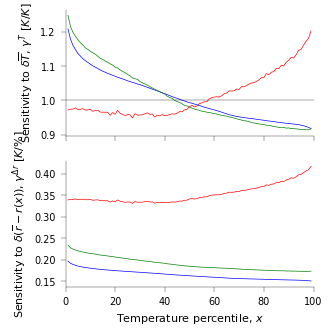

In [298]:
save_gamma_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.75*2*(width['one_col']/ar)), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(gamma_t[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    ax[1].plot(quant_plot, np.average(gamma_rdiff[i]/100, axis=0, weights=lat_weights), color=color_seq_exp[i])
ax[0].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$, $\gamma^T$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (\overline{r} - r(x))$, $\gamma^{\Delta r}$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.
There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta \chi/\delta \overline{\chi}$ plot. This should be equal to 1.
    In the top plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown in the MSE Change plot. If this approximation was exact, we would expect the solid and dashed lines to match up exactly.
   In the top plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

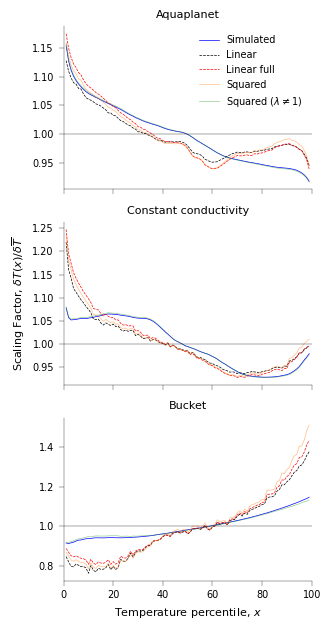

In [299]:
save_approx_fig = False
fig, ax = plt.subplots(n_exp, 1, figsize=(width['one_col'], n_exp * width['one_col']/ar), sharex=True, sharey=False)
for i in range(n_exp):
    ax[i].plot(quant_plot, np.average(((temp_quant2[i, 1]-temp_quant2[i, 0])/sf_denom['simulated'][i]), 
                                      axis=0, weights=lat_weights), label = 'Simulated', color='b')
    ax[i].plot(quant_plot, np.average((temp_diff_theory['linear'][i]/sf_denom['linear'][i]), axis=0, 
                                      weights=lat_weights), color='k', linestyle='--', label='Linear')
    ax[i].plot(quant_plot, np.average((temp_diff_theory['linear_full'][i]/sf_denom['linear_full'][i]),
                                      axis=0, weights=lat_weights), color='r', alpha=1, linestyle='--', label='Linear full')
    ax[i].plot(quant_plot, np.average((temp_diff_theory['squared'][i]/sf_denom['squared'][i]), axis=0,
                                      weights=lat_weights), color=default_colors[1], alpha=0.5, label='Squared')
    ax[i].plot(quant_plot, np.average((temp_diff_theory['squared_lambda'][i]/sf_denom['squared_lambda'][i]),
                                      axis=0, weights=lat_weights), color=default_colors[2], alpha=0.5, label='Squared ($\lambda \\neq 1$)')
    ax[i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
    ax[i].set_title(exp_names[i])
# ax.plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', linestyle='--', label='Theory $q^*(x)\delta r(x) = \overline{q^*}\delta r(x)$')
# ax.plot(quant_plot, np.average((temp_diff_theory['squared']/sf_denom['squared'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color=default_colors[1], alpha=0.5, 
#         label='Theory $q^*(x)\delta r(x) \\neq \overline{q^*}\delta r(x)$')

ax[0].legend()
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Significance of $q^*(x) \approx \overline{q^*}$ approximation
Below, I look into the $\delta r(x)$ contribution to the temperature change, and how sensitive it is to the $q^*(x) \approx \overline{q^*}$ approximation.

For the bucket, it is a bad approximation when the average is over the entire tropics, not just land.

In [300]:
# r_mean is mean sphum divided by sphum_sat evaluated at mean temp.
# This is different from the mean over all RH values
r_mean = sphum_mean / sphum_sat(temp_mean, p_surface) * 100
r_quant2 = sphum_quant2 / sphum_sat(temp_quant2, p_surface) * 100

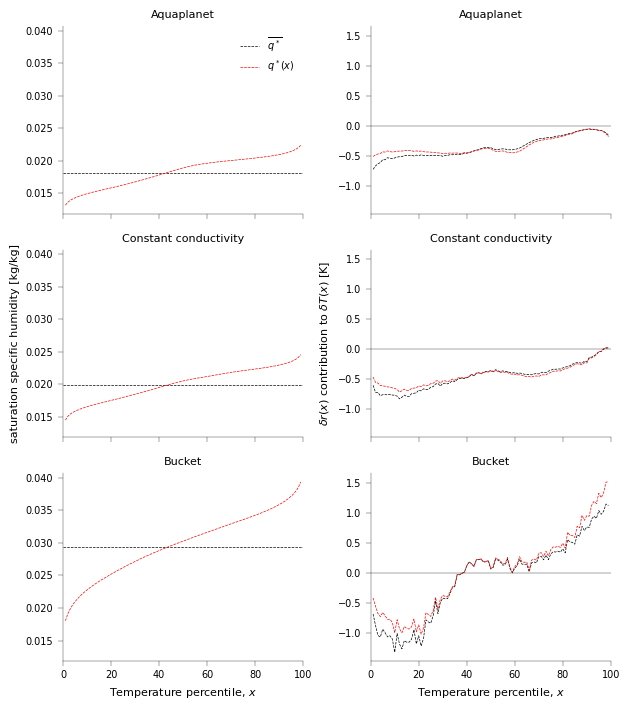

In [301]:
fig, ax = plt.subplots(n_exp, 2, figsize=(width['one_col']*2, n_exp * width['one_col']/ar), sharex=True, sharey='col')
plot_lat_ind = np.arange(n_lat)
for i in range(n_exp):  
    ax[i, 0].hlines(np.average(sphum_sat(temp_mean[i, 0, plot_lat_ind], p_surface), weights=lat_weights[plot_lat_ind], axis=0), 0, 100,
                    color='k', linestyle='--', label='$\overline{q^*}$')
    ax[i, 0].plot(quant_plot, np.average(sphum_sat(temp_quant2[i, 0, plot_lat_ind], p_surface), weights=lat_weights[plot_lat_ind], axis=0),
                  color='r', linestyle='--', label='$q^*(x)$')
    denom = c_p + L_v * clausius_clapeyron_factor(temp_quant2[i, 0, plot_lat_ind], p_surface) * sphum_quant2[i, 0, plot_lat_ind]
    ax[i, 1].plot(quant_plot, np.average(-L_v * sphum_sat(temp_mean[i, 0, plot_lat_ind], p_surface)[:, np.newaxis] * 
                                     (r_quant2[i, 1, plot_lat_ind]-r_quant2[i, 0, plot_lat_ind])/100/denom,
                                     weights=lat_weights[plot_lat_ind],axis=0), color='k', linestyle='--')
    ax[i, 1].plot(quant_plot, np.average(-L_v * sphum_sat(temp_quant2[i, 0, plot_lat_ind], p_surface) * 
                                         (r_quant2[i, 1, plot_lat_ind]-r_quant2[i, 0, plot_lat_ind])/100/denom, 
                                         weights=lat_weights[plot_lat_ind],axis=0), color='r', linestyle='--')
    ax[i, 1].hlines(0, 0, 100, colors='k', lw=ax_linewidth)
    ax[i, 0].set_title(exp_names[i])
    ax[i, 1].set_title(exp_names[i])
ax[1, 0].set_ylabel('saturation specific humidity [kg/kg]')
ax[1, 1].set_ylabel('$\delta r(x)$ contribution to $\delta T(x)$ [K]')
ax[2, 0].set_xlabel('Temperature percentile, $x$')
ax[2, 1].set_xlabel('Temperature percentile, $x$')
ax[0, 0].legend()
ax[0, 0].set_xlim(0, 100)
plt.tight_layout()

## Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$.

Note, that this relative humidity is not a physical quantity. $r(x)$ is equal to the $x$ percentile of specific humidity, $q(x)$, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x))$.

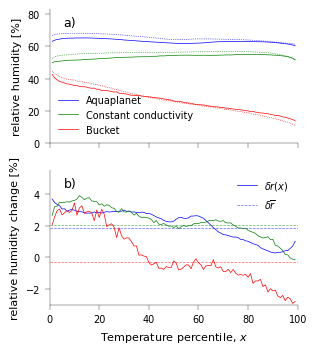

In [302]:
save_rh_fig = False

plot_var_name = 'rh'
# plot_var_name = 'sphum'
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.8*2*(width['one_col']/ar)), sharex=True)
for i in range(n_exp):
    if plot_var_name=='rh':
        plot_var = r_quant2
        plot_var_mean = r_mean
        plot_var_symb = 'r'
    else:
        plot_var = sphum_quant2
        plot_var_mean = sphum_mean
        plot_var_symb = 'q'
    for j in range(n_kappa):
        ax[0].plot(quant_plot, np.average(plot_var[i, j], axis=0, weights=lat_weights),
                   color=color_seq_exp[i], label=exp_names[i] if j==0 else None, linestyle='-' if j==0 else ':')
    ax[1].plot(quant_plot, np.average((plot_var[i, 1]-plot_var[i, 0]), axis=0, weights=lat_weights), color=color_seq_exp[i], 
               label=f'$\delta {plot_var_symb}(x)$' if i==0 else None)
    ax[1].hlines(np.average((plot_var_mean[i, 1]-plot_var_mean[i, 0]), axis=0, weights=lat_weights), 0, 100, color=color_seq_exp[i], 
                 linestyles='--', label='$\delta \overline{}$'.format('{'+plot_var_symb+'}') if i==0 else None, alpha=0.6)
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('relative humidity [%]' if plot_var_name=='rh' else 'specific humidity [kg/kg]')
ax[1].set_ylabel('relative humidity change [%]' if plot_var_name=='rh' else 'specific humidity\nchange [kg/kg]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
if plot_var_name == 'rh':
    ax[0].set_ylim(0, 83)
    ax[1].set_ylim(-3, 5.5)
else:
    ax[0].set_ylim(0, 0.02)
    ax[1].set_ylim(0.001, 0.0055)
label_subplots(fig, ax)

if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Specific humidity
Below, I plot the specific humidity in the reference (colder) simulation as a function of percentile. The fact that this increases with x is the reason we see suppressed warming of the hottest days.

I also plot the relative humidity in the colder simulation, showing how the bucket model really causes it to decrease across the temperature range.

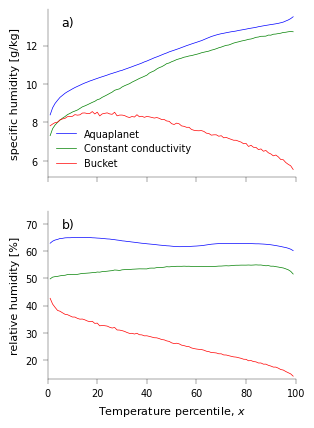

In [320]:
save_hum_fig = False
include_mean = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 1*2*(width['one_col']/ar)), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(sphum_quant2[i, 0], axis=0, weights=lat_weights)*1000, color=color_seq_exp[i], label=exp_names[i])
    ax[1].plot(quant_plot, np.average(r_quant2[i, 0], axis=0, weights=lat_weights),
                   color=color_seq_exp[i])
    if include_mean:
        ax[0].hlines(np.average(sphum_mean[i, 0], weights=lat_weights)*1000, 0, 100, colors=color_seq_exp[i], linestyle=':')
ax[0].set_xlim(0,100)
ax[0].set_ylabel('specific humidity [g/kg]')
ax[1].set_xlabel(label_quant)
ax[1].set_ylabel('relative humidity [%]')
ax[0].legend(loc='lower left')
ax[1].set_ylim(13, 75)
label_subplots(fig, ax)
if save_hum_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/hum_k={tau_lw[0]}_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Breakdown MSE Change
Below, I breakdown the MSE change contribution from temperature and relative humidity.

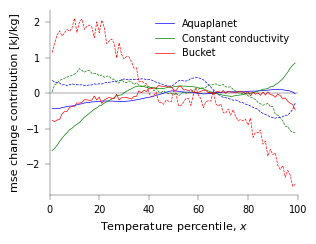

In [304]:
save_mse_change_cont_fig = False
mse_change_temp_cont = (c_p + L_v * clausius_clapeyron_factor(temp_quant2[:, 0], p_surface) * sphum_quant2[:, 0]
                        ) * (temp_quant2[:, 1]-temp_quant2[:, 0])/1000
mse_change_temp_cont_mean = (c_p + L_v * clausius_clapeyron_factor(temp_mean[:, 0], p_surface) * sphum_mean[:, 0]
                             ) * (temp_mean[:, 1]-temp_mean[:, 0])/1000
mse_change_r_cont = (L_v * sphum_sat(temp_quant2[:, 0], p_surface)) * (r_quant2[:, 1]-r_quant2[:, 0])/100/1000
mse_change_r_cont_mean = (L_v * sphum_sat(temp_mean[:, 0], p_surface)) * (r_mean[:, 1]-r_mean[:, 0])/100/1000

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_change_temp_cont[i]-np.expand_dims(mse_change_temp_cont_mean[i], -1), 
                                   weights=lat_weights, axis=0), color=color_seq_exp[i], label=exp_names[i])
    ax.plot(quant_plot, np.average(mse_change_r_cont[i]-np.expand_dims(mse_change_r_cont_mean[i], -1), 
                                   weights=lat_weights, axis=0), color=color_seq_exp[i], linestyle='--')
ax.hlines(0, 0, 100, colors='k', lw=ax_linewidth)

ax.set_xlim(0,100)
ax.legend()
ax.set_xlabel(label_quant)
ax.set_ylabel('mse change contribution [kJ/kg]')

if save_mse_change_cont_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_change_cont_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Below, for the bucket model, I do a taylor expansion of how the above contributions depend on temperature change, $\delta T$, relative humidity change, $\delta r$, temperature in ref climate, $T$ and relative humidity in ref climate, $T$.

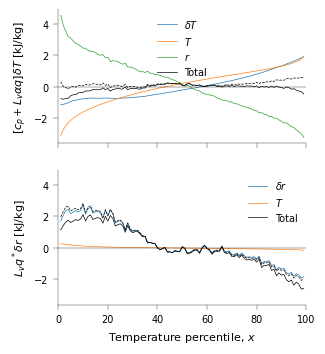

In [305]:
# Do the decomposition for the bucket model
bucket_ind = 2

alpha_mean = clausius_clapeyron_factor(temp_mean[bucket_ind, 0], p_surface)[:, np.newaxis]
sphum_sat_mean = sphum_sat(temp_mean[bucket_ind, 0], p_surface)[:, np.newaxis]
a = L_v * alpha_mean * sphum_sat_mean * (temp_mean[bucket_ind, 1]-temp_mean[bucket_ind, 0])[:, np.newaxis] * (
        r_quant2[bucket_ind, 0] - r_mean[bucket_ind, 0][:, np.newaxis])/100/1000
b = L_v * alpha_mean * sphum_mean[bucket_ind, 0][:, np.newaxis]/temp_mean[bucket_ind, 0][:, np.newaxis] * (
        alpha_mean * temp_mean[bucket_ind, 0][:, np.newaxis]-2
)/1000 * (temp_mean[bucket_ind, 1]-temp_mean[bucket_ind, 0])[:, np.newaxis] *  (
        temp_quant2[bucket_ind, 0] - temp_mean[bucket_ind, 0][:, np.newaxis])
c = (c_p + L_v * alpha_mean * sphum_mean[bucket_ind, 0][:, np.newaxis]) * ((temp_quant2[bucket_ind, 1]-temp_quant2[bucket_ind, 0]) - (temp_mean[bucket_ind, 1]-temp_mean[bucket_ind, 0])[:, np.newaxis])/1000

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.8*2*(width['one_col']/ar)), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(c, weights=lat_weights, axis=0), label='$\delta T$')
ax[0].plot(quant_plot, np.average(b, weights=lat_weights, axis=0), label='$T$')
ax[0].plot(quant_plot, np.average(a, weights=lat_weights, axis=0), label='$r$')
ax[0].plot(quant_plot, np.average((a+b+c), weights=lat_weights, axis=0), color='k', linestyle='--')
ax[0].plot(quant_plot, np.average(mse_change_temp_cont[bucket_ind]-np.expand_dims(mse_change_temp_cont_mean[bucket_ind], -1), 
                               weights=lat_weights, axis=0), color='k', label='Total')
ax[0].hlines(0, 0, 100, colors='k', lw=ax_linewidth)
ax[0].legend()

a = np.expand_dims(L_v * sphum_sat(temp_mean[bucket_ind, 0], p_surface), -1)/1000 * ((r_quant2[bucket_ind, 1]-r_quant2[bucket_ind, 0]) - 
                                                                         np.expand_dims((r_mean[bucket_ind, 1]-r_mean[bucket_ind, 0]), -1))/100
b = L_v * np.expand_dims((r_mean[bucket_ind, 1]-r_mean[bucket_ind, 0]), -1) * sphum_sat_mean * alpha_mean * (
        temp_quant2[bucket_ind, 0]- temp_mean[bucket_ind, 0][:, np.newaxis])/100/1000
ax[1].plot(quant_plot, np.average(a, weights=lat_weights, axis=0), label='$\delta r$')
ax[1].plot(quant_plot, np.average(b, weights=lat_weights, axis=0), label='$T$')
ax[1].plot(quant_plot, np.average((a+b), weights=lat_weights, axis=0), color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(mse_change_r_cont[bucket_ind]-np.expand_dims(mse_change_r_cont_mean[bucket_ind], -1), 
                                weights=lat_weights, axis=0), color='k', label='Total')
ax[1].legend()
ax[1].hlines(0, 0, 100, colors='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$[c_p + L_v\\alpha q]\delta T$ [kJ/kg]')
ax[1].set_ylabel('$L_v q^*\delta r$ [kJ/kg]')
ax[1].set_xlabel(label_quant);

## Bucket Model Specific Plots

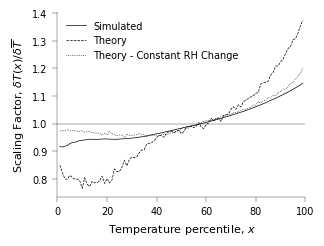

In [306]:
save_bucket_theory_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average((temp_quant2[bucket_ind, 1]-temp_quant2[bucket_ind, 0])/sf_denom['simulated'][bucket_ind], axis=0,
                               weights=lat_weights), label = 'Simulated', color='k')
ax.plot(quant_plot, np.average(temp_diff_theory['linear'][bucket_ind]/sf_denom['linear'][bucket_ind], axis=0, weights=lat_weights), 
        color='k', linestyle='--', label='Theory')
ax.plot(quant_plot, np.average(temp_diff_theory['const_rh'][bucket_ind]/sf_denom['const_rh'][bucket_ind], axis=0, weights=lat_weights), 
        color='k', linestyle=':', label='Theory - Constant RH Change')
# ax[1].plot(quant_plot, np.average(((temp_quant2[1]-temp_quant2[0])/sf_denom['simulated'])[lat_use],
#                                   axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
# ax[1].plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', linestyle='--')
# ax[1].plot(quant_plot, np.average((temp_diff_theory['const_rh']/sf_denom['const_rh'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', label='Theory - Constant RH Change', linestyle=':')
ax.hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$\delta T(x)$ [$K$]')
ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax.set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
# ax[1].set_ylim(0.8, 1.3)

if save_fig or save_bucket_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/theory_bucket_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

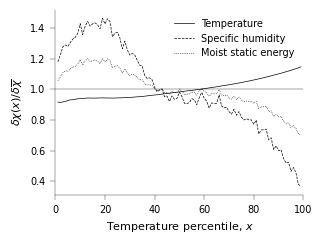

In [307]:
save_bucket_lambda_fig = False
bucket_ind = 2
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels = ['Temperature','Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean[bucket_ind], sphum_mean[bucket_ind], mse_mean[bucket_ind]]]
linestyles_lambda = ['-', '--', ':']
for i, var in enumerate([temp_quant2[bucket_ind], sphum_quant2[bucket_ind], mse_quant2[bucket_ind]]):
    var_ratio = ((var[1]-var[0])/delta_var_mean[i])
    ax.plot(quant_plot, np.average(var_ratio, axis=0, weights=lat_weights), label=labels[i], color='k', linestyle=linestyles_lambda[i])
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend()
ax.set_xlabel(label_quant)
ax.set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
# ax.set_ylim(0.4,1.6)
ax.set_xlim(0, 100)
if save_fig or save_bucket_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_bucket_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

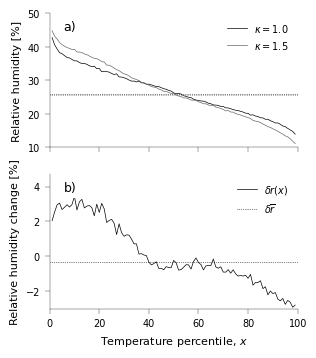

In [308]:
save_bucket_rh_fig = False
# choose which mean rh to plot - r_mean is mean over all RH values. r_mean2 is mean sphum divided by sphum_sat evaluated at mean temp.
color_seq_rh = plt.cm.Greys(np.linspace(0,1,n_exp+1))[1:][::-1]
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.8*2*(width['one_col']/ar)), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(r_quant2[bucket_ind, i], axis=0, weights=lat_weights),
               color=color_seq_rh[i], label='$\kappa={:.1f}$'.format(tau_lw[i]))
    ax[0].hlines(np.average(r_mean[bucket_ind, i], weights=lat_weights), 0, 100, color=color_seq_rh[i], linestyle=':')
ax[1].plot(quant_plot, np.average((r_quant2[bucket_ind, 1]-r_quant2[bucket_ind, 0]), axis=0, weights=lat_weights), 
           color='k', label='$\delta r(x)$')
ax[1].hlines(np.average((r_mean[bucket_ind, 1]-r_mean[bucket_ind, 0]), axis=0, weights=lat_weights), 0, 100, color='k', 
             linestyles=':', label='$\delta \overline{r}$')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Relative humidity [%]')
ax[1].set_ylabel('Relative humidity change [%]')
ax[0].legend(frameon=False, loc='upper right')
ax[1].legend(frameon=False)
ax[0].set_ylim(10, 50)
ax[1].set_ylim(-3, 4.7)
label_subplots(fig, ax)

if save_fig or save_bucket_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_bucket_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Print range of $\lambda = \delta h(x) / \delta \overline{h}$ and relative humidity changes relative to mean, $\delta (\overline{r}-r(x))$ for aquaplanet and land. This is to show that the range is larger for land.

In [309]:
for i in [0, bucket_ind]:
    print(f'{exp_names[i]} min lambda: {round(np.average(delta_mse_ratio[i], axis=0, weights=lat_weights).min(), 2)}')
    print(f'{exp_names[i]} max lambda: {round(np.average(delta_mse_ratio[i], axis=0, weights=lat_weights).max(), 2)}')

Aquaplanet min lambda: 0.94
Aquaplanet max lambda: 1.04
Bucket min lambda: 0.7
Bucket max lambda: 1.2


In [310]:
for i in [0, bucket_ind]:
    rh_rel_mean_use = (np.average((r_mean[i, 1]-r_mean[i, 0]), axis=0, weights=lat_weights) - 
                       np.average((r_quant2[i, 1]-r_quant2[i, 0]), axis=0, weights=lat_weights))
    print(f'{exp_names[i]} min (r_mean - r) change: {round(rh_rel_mean_use.min(), 2)}%')
    print(f'{exp_names[i]} max (r_mean - r) change: {round(rh_rel_mean_use.max(), 2)}%')

Aquaplanet min (r_mean - r) change: -1.83%
Aquaplanet max (r_mean - r) change: 1.59%
Bucket min (r_mean - r) change: -3.75%
Bucket max (r_mean - r) change: 2.61%
